In [1]:
import os
import deepcell

import tensorflow as tf
import numpy as np
import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats

In [2]:
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

def load_data(path, mode, test_size=0.1, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

## Set up file path constants

In [4]:
import errno

ROOT_DIR = '../track_train'  # TODO: Change this! Usually a mounted volume

MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))
#DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
OUTPUT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'nuc_tracking'))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR, OUTPUT_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [5]:
(X_train, y_train), (X_test, y_test) = load_data('../train_small.npz', mode='sample')
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (78, 100, 530, 530, 1)
y.shape: (78, 100, 530, 530, 1)


In [21]:
trks_stats("../train_small.trks")

Dataset Statistics: 
Image data shape:  (87, 100, 530, 530, 1)
Number of lineages (should equal batch size):  87
Total number of unique tracks (cells)      -  205
Total number of divisions                  -  0
Average cell density (cells/100 sq pixels) -  0.0004724551216737661
Average number of frames per track         -  70


## Prepare the data

To facilitate training, we transform each movie's image and lineage data into a `Track` object.
`Tracks` help to encapsulate all of the feature creation from the movie, including:

* Appearances: `(num_frames, num_objects, 32, 32, 1)`
* Morphologies: `(num_frames, num_objects, 32, 32, 3)`
* Centroids: `(num_frames, num_objects, 2)`
* Normalized Adjacency Matrix: `(num_frames, num_objects, num_objects, 3)`
* Temporal Adjacency Matrix (comparing across frames): `(num_frames - 1, num_objects, num_objects, 3)`

All `Track` objects are then concatenated with each other (using `concat_tracks`) resulting in a single array for each feature.

In [6]:
# TODO: use 22956814_seq.trks as a test first  ### Because it requires sequential labels as well

trks_data = load_trks('../train_small.trks')

In [7]:
%%time

from deepcell_tracking.utils import Track

all_tracks = Track(tracked_data=trks_data)

CPU times: user 3min 41s, sys: 29.5 s, total: 4min 10s
Wall time: 4min 10s


In [8]:
%%time

from deepcell_tracking.utils import concat_tracks

track_info = concat_tracks([all_tracks])
for k, v in track_info.items():
    print(k, v.shape)

appearances (87, 100, 20, 32, 32, 1)
centroids (87, 100, 20, 2)
morphologies (87, 100, 20, 3)
adj_matrices (87, 100, 20, 20)
norm_adj_matrices (87, 100, 20, 20)
temporal_adj_matrices (87, 99, 20, 20, 3)
CPU times: user 282 ms, sys: 553 ms, total: 835 ms
Wall time: 833 ms


In [9]:
######GRRRRRRRRRRREAT!!!!



## Set up training parameters

In [10]:
seed = 1   # random seed for training/validation data split
batch_size = 16
track_length = 8  # only train on 8 frames at once  ## 8
val_size = .20  # % of data saved as validation
test_size = .1  # % of data held out as a test set
n_epochs = 12  # number of training epochs

steps_per_epoch = 20  ## 1000
validation_steps = 10  ## 200

# find maximum number of cells in any frame
max_cells = track_info['appearances'].shape[2]

n_layers = 1  # number of graph convolutions

translation_range = X_train.shape[-2]

model_name = 'graph_tracking_model_seed{}'.format(seed)
model_path = os.path.join(MODEL_DIR, model_name)

## Create Tracking Dataset object

We then assemble `Tracks` as specified into a Tracking `Dataset` that is used during training

In [11]:
from deepcell.data.tracking import prepare_dataset


train_data, val_data, test_data = prepare_dataset(
    track_info,
    rotation_range=180,
    translation_range=translation_range,
    seed=seed,
    val_size=val_size,
    test_size=test_size,
    batch_size=batch_size,
    track_length=track_length)

2021-08-23 07:11:36.525794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-23 07:11:36.540334: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1999995000 Hz
2021-08-23 07:11:36.544739: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5612a7936a70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-23 07:11:36.544765: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-23 07:11:36.545021: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/pyth

## Instantiate and Compile the Model
The goal is to predict the adjacency matrix and daughter adjacency matrix by attending over the edges provided by the spatiotemporal adjacency matrix (SAM). The SAM is constructed by linking cells that are in temporal or spatial proximity.

In [12]:
from deepcell.model_zoo.tracking import GNNTrackingModel

tm = GNNTrackingModel(max_cells=max_cells, n_layers=n_layers)

2021-08-23 07:11:39.278448: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Before a model can be trained, it must be compiled with the chosen optimizer, loss function, and metrics.

This model uses padded data which must be flattened and filtered out before calling our metrics and loss.

In [13]:
def filter_and_flatten(y_true, y_pred):
    n_classes = tf.shape(y_true)[-1]
    new_shape = [-1, n_classes]
    y_true = tf.reshape(y_true, new_shape)
    y_pred = tf.reshape(y_pred, new_shape)

    # Mask out the padded cells
    good_loc = tf.where(y_true[:, 0] != -1)[:, 0]

    y_true = tf.gather(y_true, good_loc, axis=0)
    y_pred = tf.gather(y_pred, good_loc, axis=0)
    return y_true, y_pred


class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Recall, self).update_state(y_true, y_pred, sample_weight)


class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = filter_and_flatten(y_true, y_pred)
        super(Precision, self).update_state(y_true, y_pred, sample_weight)


def loss_function(y_true, y_pred):
    y_true, y_pred = filter_and_flatten(y_true, y_pred)
    return deepcell.losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=tf.shape(y_true)[-1],
        axis=1)

In [14]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam


# Define optimizer
optimizer = RAdam(lr=1e-3, clipnorm=0.001)

# Define the loss function
losses = {'temporal_adj_matrices': loss_function}

# Define metrics
metrics = [
    Recall(class_id=0, name='same_recall'),
    Recall(class_id=1, name='different_recall'),
    Recall(class_id=2, name='daughter_recall'),
    Precision(class_id=0, name='same_precision'),
    Precision(class_id=1, name='different_precision'),
    Precision(class_id=2, name='daughter_precision'),
]

In [15]:
# Compile model
tm.training_model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Train Model and Verify Performance

Call fit on the compiled model, along with a defined set of callbacks.

In [16]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


# Verify GPU count
from deepcell import train_utils
num_gpus = train_utils.count_gpus()
print('Training on {} GPUs'.format(num_gpus))

# Train the model
train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
]

loss_history = tm.training_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks)

Training on 0 GPUs


2021-08-23 07:11:42.535591: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/12
20/20 [==============================] - ETA: 0s - loss: 1.1145 - same_recall: 0.9454 - different_recall: 0.0061 - daughter_recall: 0.0000e+00 - same_precision: 0.1726 - different_precision: 0.4618 - daughter_precision: 0.0000e+00
Epoch 00001: val_loss improved from inf to 1.06058, saving model to /home/jupyter/track_train/models/graph_tracking_model_seed1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/jupyter/track_train/models/graph_tracking_model_seed1/assets
20/20 [==============================] - 86s 4s/step - loss: 1.1145 - same_recall: 0.9454 - different_recall: 0.0061 - daughter_recall: 0.0000e+00 - same_precision: 0.1726 - different_precision: 0.4618 - daughter_precision: 0.0000e+00 - val_loss: 1.0606 - val_same_recall: 1.0000 - val_differen

Visualize the performance of the model by comparing the predicted classes of i frames in j movies

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


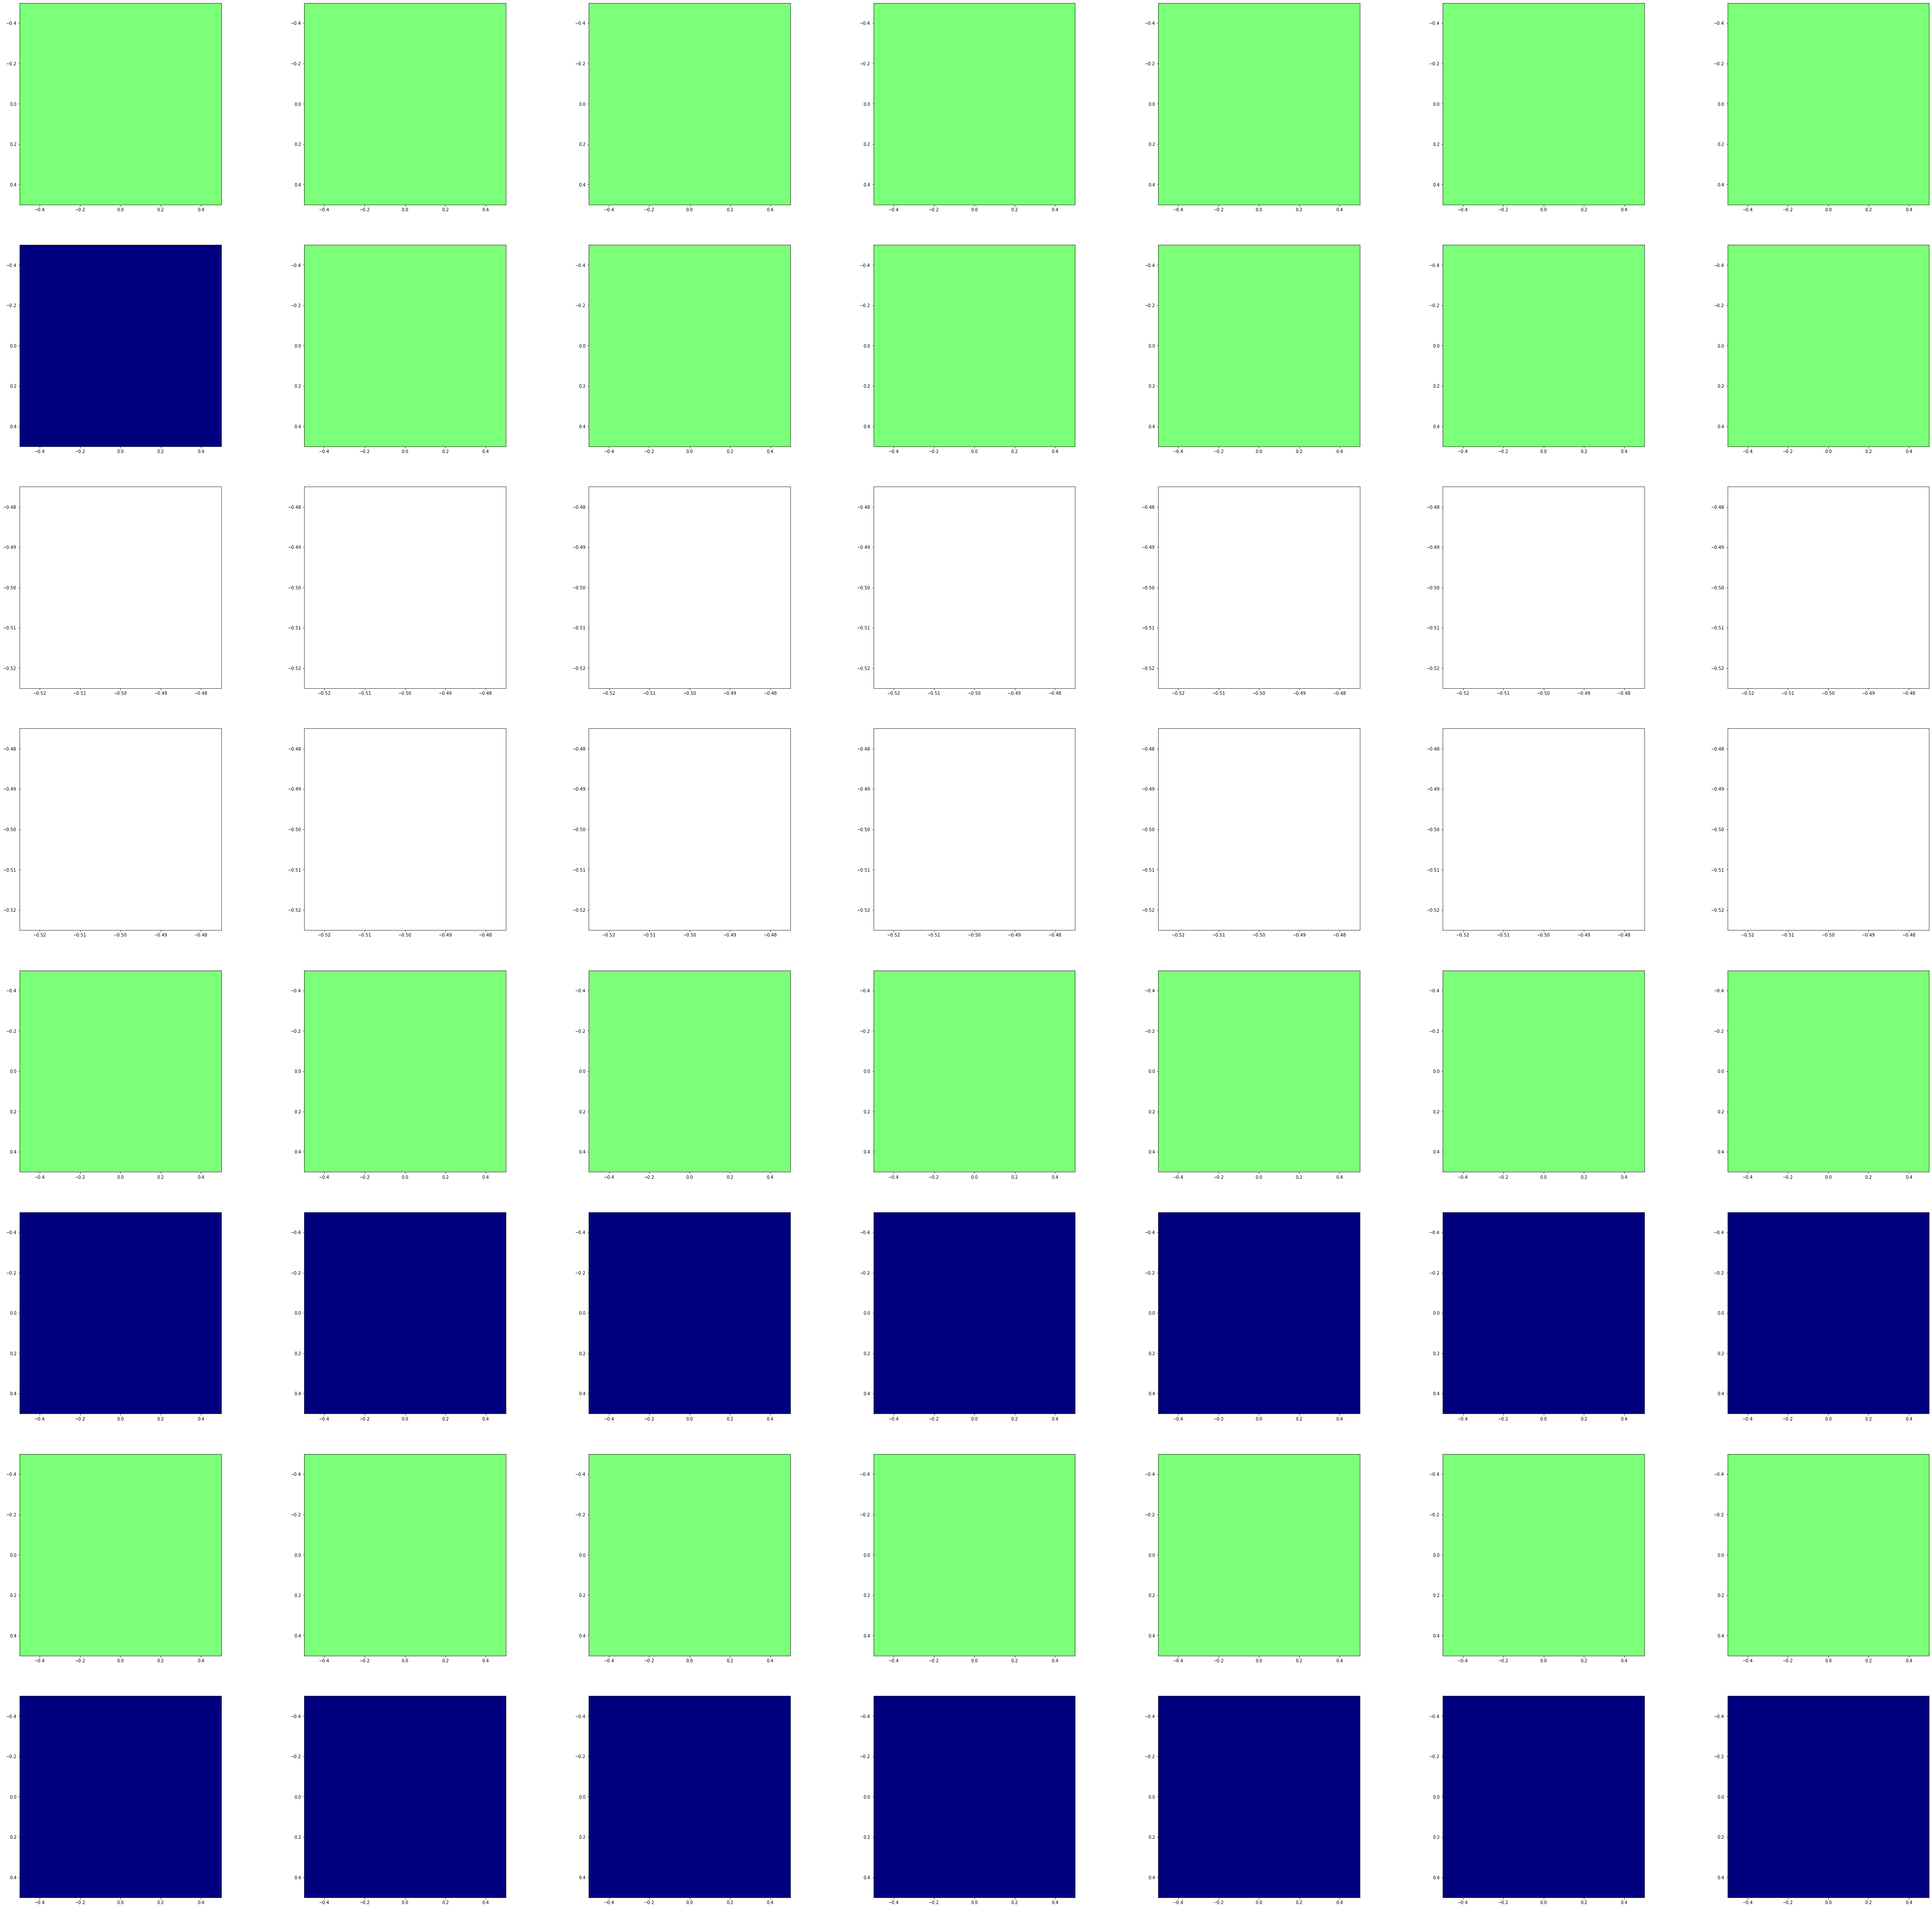

In [17]:
from matplotlib import pyplot as plt

it = val_data.as_numpy_iterator()
x_temp, y_temp = it.next()

temp_adj = y_temp['temporal_adj_matrices']

output = tm.training_model.predict(x_temp)

fig, axes = plt.subplots(8, 7, figsize=(80, 80))

for j in range(4):
    for i in range(7):
        pred = output[j, i, ...]
        truth = temp_adj[j, i, ...]

        summed = np.sum(truth, axis=-1)
        bad_loc = np.where(summed == -3)[1]
        end = bad_loc[0] - 1
        summed = np.sum(truth, axis=-1)

        axes[2 * j, i].imshow(
            np.argmax(pred[0:end, 0:end, :], axis=-1),
            cmap='jet', vmin=0, vmax=2)
        axes[2 * j + 1, i].imshow(
            np.argmax(truth[0:end, 0:end, :]==1, axis=-1),
            cmap='jet', vmin=0, vmax=2)

## Save the Model

In [23]:
# Save models for prediction
inf_path = os.path.join(MODEL_DIR, 'TrackingModelInf')
ne_path = os.path.join(MODEL_DIR, 'TrackingModelNE')

#tm.inference_model.save(inf_path)
#tm.neighborhood_encoder.save(ne_path)

## Use save_weights
tm.inference_model.save_weights(inf_path)
tm.neighborhood_encoder.save_weights(ne_path)

## Next Steps

This model is used within an assignment problem framework to track cells through time-lapse sequences and build cell lineages. To see how this works on example data, see below. 

To use existing models for tracking (and segmentation), refer to its counterpart in the `deepcell.application` [notebook series](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Nuclear-Application.ipynb).

## Load the Model and Track One Movie

In [27]:
# Instantiate Models
from deepcell.model_zoo.tracking import GNNTrackingModel
tm = GNNTrackingModel()

from tensorflow.keras import Model

# Load models for prediction
# (update `ne_path` and `inf_path` if different from above)
##tm.neighborhood_encoder = tf.keras.models.load_model(ne_path)
##tm.inference_model = tf.keras.models.load_model(inf_path)

tm.neighborhood_encoder.load_weights(ne_path)
tm.inference_model.load_weights(inf_path)

In [ ]:
# Alter below

In [35]:
# Choose and load a dataset to track using the trained model
benchmark_filename = '../22956814/22956814_str.trks'  ## Use a deepcell segmented? ### TODO: later
(X_train, y_train), (X_test, y_test) = load_data("../22956814/22956814_str.npz", mode='sample')
print('Val Data -\nX.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

path_bench_trks = os.path.join(benchmark_filename)
test_data = load_trks(path_bench_trks)

benchmark_index = 1  # this one has divisions

raw_images = test_data['X'][benchmark_index]
labeled_movie = test_data['y'][benchmark_index]

Val Data -
X.shape: (23, 100, 530, 530, 1)
y.shape: (23, 100, 530, 530, 1)


### Import the cell tracking algorithm and track the movie

In [ ]:
from deepcell_tracking import CellTracker

npz = np.load("../6814_2/6814_2_str.npz")
raw_images = npz['X'][0]
labeled_movie = npz['y'][0]



cell_tracker = CellTracker(
    movie=raw_images,
    annotation=labeled_movie,
    track_length=track_length,
    neighborhood_encoder=tm.neighborhood_encoder,
    tracking_model=tm.inference_model)

In [ ]:
%%time

cell_tracker.track_cells()

### Review the results

In [ ]:
# View tracked results of each batch as a video
# NB: This does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

# Raw
HTML(get_js_video(np.expand_dims(raw_images, axis=0),
                  batch=0, cmap='gray'))

In [ ]:
# Tracked

# Scale the colors to match the max cell label
HTML(get_js_video(np.expand_dims(cell_tracker.y_tracked, axis=0),
                  batch=0, cmap='cubehelix', vmin=0,
                  vmax=len(cell_tracker.tracks)))

# Save the Output

If desired, save the results in our compressed format (.trk - with lineage information), as a movie (.gif - images only/no lineage information), or both

In [ ]:
# Save trk file
res_file_path = os.path.join(OUTPUT_DIR, 'hek_test.trk')
cell_tracker.dump(res_file_path)

Optionally, save the output as `.tif` files or `.gif` files for easy inspection.

In [ ]:
import imageio

vmax = len(cell_tracker.y_tracked)

raw = []
tracked = []

for i in range(cell_tracker.X.shape[0]):
    new_image = cell_tracker.X[i, ..., 0]
    raw_path = os.path.join(OUTPUT_DIR, 'image_%d.tiff' % i)
    imageio.imwrite(raw_path, new_image.astype('uint8'))
    raw.append(new_image.astype('uint8'))

    label_image = cell_tracker.y_tracked[i, ..., 0].astype('uint8')
    label_path = os.path.join(OUTPUT_DIR, 'label_%d.tiff' % i)
    plt.imsave(label_path, label_image,
               cmap='cubehelix', vmin=0, vmax=vmax)
    # imageio.imwrite(label_path, label_image,
    #                 cmap='cubehelix', vmin=0, vmax=vmax)
    tracked.append(label_image.astype('uint8'))

# Make gifs
imageio.mimsave(os.path.join(OUTPUT_DIR, 'raw.gif'), raw)
imageio.mimsave(os.path.join(OUTPUT_DIR, 'tracked.gif'), tracked)

In [ ]:
# Benchmarked results not included here... See the original notebook